In [1]:
import numpy as np
import pandas as pd
import os as os
import time



In [2]:
os.chdir('../')

In [3]:
%pylab inline
exec(open("./run_model.py").read())
exec(open("./get_signal_names.py").read())
exec(open("./portfolio_optimizer.py").read())

import datetime
from pylab import rcParams


Populating the interactive namespace from numpy and matplotlib


In [4]:
sig_type = 'rank'
#rank
#norm
size_tag = '500_3000'
#0_3000
#0_500
#500_3000
#use_pickle = True 


    

sig_dir =      '../afp_data/' + sig_type + '/' +  size_tag + '/rps_data/'
fac_data_dir=  '../afp_data/' + sig_type + '/' +  size_tag + '/factor_exposure_data/'
fac_ret_file = '../afp_data/' + sig_type + '/' +  size_tag + '/fac_ret_file.csv'
    
    

In [5]:
use_pickle = True 

if use_pickle :
    file_name = '../afp_pickle/'+'sig_'+sig_type +'_'+size_tag +'.pkl' 
    sig_df = pd.read_pickle(file_name)
    #sig_df = pd.read_pickle('../afp_pickle/_rank_0_500.pkl')
else :
    sig_df = pd.DataFrame()
    sig_files = os.listdir(sig_dir)
    sig_files = np.sort(sig_files)



    for sig_file in sig_files :
        if '.csv' not in sig_file :
            continue
        print(sig_file)
        this_file = sig_dir + sig_file
        this_df = pd.read_csv(this_file, index_col = 'date')
        this_df.index = [ datetime.datetime.strptime(val, '%Y-%m-%d') for val in this_df.index]
        #this_df = this_df.sort_values(['mve'], ascending=False)
        #this_df = this_df.iloc[start_stock_ind:end_stock_ind,:]
        sig_df = sig_df.append(this_df)
    #data = sig_df.copy()

In [6]:
#model_name = 'linear_regression'
#train_model_arg = { 'fit_intercept':True }

model_name = 'knn'
train_model_arg = None



In [7]:
begin_date = datetime.datetime.strptime('19900101', '%Y%m%d')
end_date = datetime.datetime.strptime('20170101', '%Y%m%d')

sig_df = sig_df[(sig_df.index>=begin_date) & (sig_df.index<end_date)]
sig_df = sig_df.fillna(sig_df.mean())

In [8]:
'res_ret' in sig_df.columns

True

In [9]:
#factor_names =  ['beta','mve', 'bm', 'roic', 'agr', 'mom12m', 'idiovol']
factor_names =  ['beta']
sig_names = get_signal_names()
ret_sr = sig_df['ret']
sig_df = sig_df[sig_names]
sig_df = sig_df.drop(factor_names, axis=1)
sig_df = sig_df.drop(['idiovol'], axis=1)

In [10]:
pm = PortfolioOptimizer(fac_data_dir=fac_data_dir,
                        fac_ret_file = fac_ret_file,
                        fac_cov_hl = 12.0,
                        fac_names = None
                       )

--------


In [11]:
look_back = 1

knn_sig_df = pd.DataFrame()
lm_sig_df = pd.DataFrame()
kernel_sig_df = pd.DataFrame()

pnl_df = pd.DataFrame()
lm_pnl_df = pd.DataFrame()
knn_pnl_df = pd.DataFrame()
#kernel_pnl_df = pd.DataFrame()

shrp_df = pd.DataFrame()

#these_signals = ['mve', 'bm', 'roic', 'agr', 'mom12m',]
these_signals = sig_df.columns

for sig_name in these_signals :
    print(sig_name)
    
    try :
        t0 = time.time()
        
        this_sig_sr = sig_df[ [sig_name] ].copy()
        #unmodified signal
        pnl_sr = pm.run_signal(this_sig_sr.iloc[:,0], neu_sig=True)
        pnl_df[sig_name] = pnl_sr
        
        #linear signal
        print('lm')
        lm_sig_sr,mvc = run_model( this_sig_sr, ret_sr, model_name='linear_regression', train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back, sample_decay = 0.0)
        lm_sig_df[sig_name] = lm_sig_sr
        lm_pnl_sr = pm.run_signal(lm_sig_sr, neu_sig=True)
        lm_pnl_df[sig_name] = lm_pnl_sr
        
        #knn signal
        print('knn')
        knn_sig_sr,mvc = run_model( this_sig_sr, ret_sr, model_name='knn', train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back, sample_decay = 0.0)
        knn_sig_df[sig_name] = knn_sig_sr   
        knn_pnl_sr = pm.run_signal(knn_sig_sr, neu_sig=True)
        knn_pnl_df[sig_name] = knn_pnl_sr
        
        #kernel signal
        #print('kernel')
        #kernel_sig_sr,mvc = run_model( this_sig_sr, ret_sr, model_name='ridge_kernel', train_model_arg=train_model_arg, 
        #                  pred_model_arg ={},look_back=look_back, sample_decay = 0.5)
        #kernel_sig_df[sig_name] = kernel_sig_sr   
        #kernel_pnl_sr = pm.run_signal(kernel_sig_sr, neu_sig=True)
        #kernel_pnl_df[sig_name] = kernel_pnl_sr
        
        
        s1 = pnl_sr.mean()*sqrt(12)/ pnl_sr.std()
        s2 = lm_pnl_sr.mean()*sqrt(12)/ lm_pnl_sr.std()
        s3 = knn_pnl_sr.mean()*sqrt(12)/ knn_pnl_sr.std()
        #s4  = kernel_pnl_sr.mean()*sqrt(12)/ kernel_pnl_sr.std()
        
        #this_shrp = pd.Series([s1,s2,s3,s4], index=['org', 'lm', 'knn', 'kernel'], name = sig_name)
        this_shrp = pd.Series([s1,s2,s3], index=['org', 'lm', 'knn',], name = sig_name)
        shrp_df = shrp_df.append(this_shrp)
        
        t1 = time.time()
        this_time = t1-t0
        print('time = ' + str(this_time)) 
        print(this_shrp)
        
    except Exception as e :
        print(e)

absacc
-----------
lm
-----------
-----------
knn
-----------
-----------
time = 70.58668494224548
org   -0.256707
lm     0.248757
knn    0.342400
Name: absacc, dtype: float64
acc
-----------
lm
-----------
-----------
knn
-----------
-----------
time = 66.16536593437195
org   -0.178190
lm     0.258891
knn    0.467904
Name: acc, dtype: float64
aeavol
-----------
lm
-----------
-----------
knn
-----------
-----------
time = 61.52542185783386
org   -0.181104
lm    -0.022908
knn   -0.073287
Name: aeavol, dtype: float64
age
-----------
lm
-----------
-----------
knn
-----------
-----------
time = 68.83527302742004
org    0.790088
lm     0.284635
knn    0.304606
Name: age, dtype: float64
agr
-----------
lm
-----------
-----------
knn
-----------
-----------
time = 63.713977098464966
org   -0.846595
lm     0.361842
knn    0.341604
Name: agr, dtype: float64
baspread
-----------
lm
-----------
-----------
knn
-----------
-----------
time = 62.441100120544434
org   -1.399495
lm     0.152876
knn

In [12]:

knn_sig_df.to_csv('/Users/raghuramkowdeed/Desktop/knn_sig_df_'+str(look_back)+ '.csv')

In [19]:
import seaborn as sns
sns.set(color_codes=True)


-----------
-----------
sharpe ratio = 0.442689699027


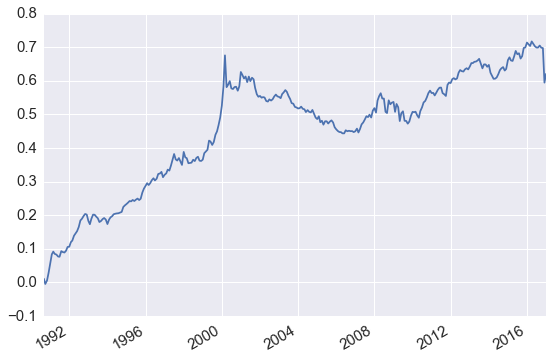

In [20]:
model_name = 'linear_regression'
train_model_arg = None
this_ret_sr = ret_sr[ (ret_sr.index>=knn_sig_df.index[0]) & (ret_sr.index<=knn_sig_df.index[-1])]

all_lm_sig_sr, all_lm_model_vec = run_model( knn_sig_df, this_ret_sr, model_name, train_model_arg=None, 
                          pred_model_arg ={},look_back=6, sample_decay = 0.5, signs_vec=None)
all_lm_pnl_sr = pm.run_signal(all_lm_sig_sr, neu_sig=True)
all_lm_pnl_sr.cumsum().plot(fontsize=15, figsize =  (9,6))
all_lm_shrp = all_lm_pnl_sr.mean()*sqrt(12)/all_lm_pnl_sr.std()
print( 'sharpe ratio = ' + str(all_lm_shrp) )
#pylab.title('lm_all')

In [15]:
knn_sig_df.shape

(807500, 99)

In [16]:
this_ret_sr.shape

(2500,)